| Columna       | Descripción                                                                                       |
|---------------|---------------------------------------------------------------------------------------------------|
| id            | Identificador único de cada paciente.                                                             |
| age           | Edad del paciente expresada en días.                                                              |
| gender        | Género (1 = mujer, 2 = hombre).                                                                   |
| height        | Estatura del paciente en centímetros.                                                             |
| weight        | Peso del paciente en kilogramos.                                                                  |
| ap_hi         | Presión arterial sistólica (cuando el corazón late), medida en mmHg.                              |
| ap_lo         | Presión arterial diastólica (cuando el corazón está en reposo), en mmHg.                          |
| cholesterol   | Nivel de colesterol: 1 = normal, 2 = por encima de lo normal, 3 = muy por encima de lo normal.   |
| gluc          | Nivel de glucosa: 1 = normal, 2 = por encima de lo normal, 3 = muy por encima de lo normal.      |
| smoke         | Indica si la persona fuma (0 = no, 1 = sí).                                                       |
| alco          | Indica si la persona consume alcohol (0 = no, 1 = sí).                                            |
| active        | Indica si la persona realiza actividad física (0 = no, 1 = sí).                                   |
| cardio        | Variable objetivo: presencia de enfermedad cardiovascular (0 = no, 1 = sí).                       |


In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder \
    .appName("CardioSparkModel") \
    .getOrCreate()


In [15]:
#Importar dataset a Spark 

df_spark = spark.read.csv("cardio_train.csv", header=True, inferSchema=True, sep=";")
df_spark.show()


+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|  4|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
|  8|21914|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|
|  9|22113|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0|
| 12|22584|     2|   178|  95.0|  130|   90|          3|   3|    0|   0|     1|     1|
| 13|17668|     1|   158|  71.0|  110|   70

In [16]:
df_spark.printSchema()


root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)



### Fórmula del Índice de Masa Corporal (BMI)

$
BMI = \frac{\text{peso (kg)}}{(\text{estatura (m)})^2}
$


In [17]:
df_spark = df_spark.withColumn("age_years", col("age")/365) # Calculo de Edad
df_spark = df_spark.withColumn("bmi", col("weight") / ((col("height")/100)**2))# Calculo de Masa Corporal Se dicide entre 100 por que la estatura en el data set esta en Cm

df_spark.show()

+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------------+------------------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|         age_years|               bmi|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------------+------------------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|50.391780821917806|  21.9671201814059|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1| 55.41917808219178|34.927679158448385|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1| 51.66301369863014|23.507805325987146|
|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1| 48.28219178082192| 28.71047932495361|
|  4|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0| 47.87397260273973|23.011176857330703|


StringIndexer sirve para convertir variables categóricas en números, porque los modelos de Machine Learning solo trabajan con variables numéricas.

En el dataset:

cholesterol tiene valores: 1, 2, 3

gluc tiene valores: 1, 2, 3

Aunque parezcan números, no representan cantidades, sino categorías.

Ejemplo:
No es cierto que "3 de colesterol" sea tres veces más colesterol que "1".
Son solo niveles de riesgo, no valores continuos.

➡ Por eso se convierten a índices internos:

categoría 1 → índice 0.0

categoría 2 → índice 1.0

categoría 3 → índice 2.0

In [18]:

#StringIndexer toma una columna que contiene categorías 
# (texto o números que representan clases) y las convierte 
# en índices numéricos para que los modelos de Machine Learning de PySpark las puedan usar.

indexer_chol = StringIndexer(inputCol="cholesterol", outputCol="cholesterol_idx")
indexer_gluc = StringIndexer(inputCol="gluc", outputCol="gluc_idx")

df_spark = indexer_chol.fit(df_spark).transform(df_spark)
df_spark = indexer_gluc.fit(df_spark).transform(df_spark)

df_spark.show()


+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------------+------------------+---------------+--------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|         age_years|               bmi|cholesterol_idx|gluc_idx|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------------+------------------+---------------+--------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|50.391780821917806|  21.9671201814059|            0.0|     0.0|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1| 55.41917808219178|34.927679158448385|            2.0|     0.0|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1| 51.66301369863014|23.507805325987146|            2.0|     0.0|
|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1| 48.2821917808

¿Para qué sirve VectorAssembler?

Cuando vas a entrenar un modelo en PySpark MLlib, este solo acepta las variables de entrada dentro de una sola columna llamada features, que contiene un vector numérico.
No acepta columnas separadas como sí lo hace pandas o scikit-learn.

In [19]:

# Definir que columnas se requiere unir para crear un solo vector
assembler = VectorAssembler(
    inputCols=[
        "age_years","bmi","ap_hi","ap_lo","cholesterol_idx","gluc_idx",
        "smoke","alco","active"
    ],
    outputCol="features"
)

data = assembler.transform(df_spark).select("features", "cardio")

#inputCols: variables predictoras (X).
#outputCol: nombre de la nueva columna donde quedará el vector.

In [20]:
#dividir el data set
train, test = data.randomSplit([0.7, 0.3], seed=42)


In [21]:
#Modelo predictivo Logistico Regresión Lineal 


lr = LogisticRegression(labelCol="cardio", featuresCol="features")
modelo_spark = lr.fit(train)


In [22]:
pred = modelo_spark.transform(test)


In [23]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="cardio", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)

auc = evaluator.evaluate(pred)
print("AUC:", auc)


AUC: 0.7839138193011427


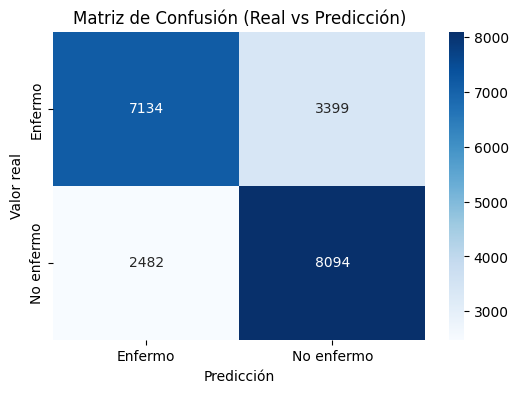

In [27]:

# 1. Matriz de confusión en PySpark

conf = (
    pred
    .groupBy("cardio", "prediction")
    .count()
    .orderBy("cardio", "prediction")
)

# Convertir a Pandas
conf_pd = conf.toPandas()


# Convertir a Pandas
conf_pd = conf.toPandas()


# 2. Reemplazar 0/1 por etiquetas

label_map = {0: "No enfermo", 1: "Enfermo"}

conf_pd["cardio"] = conf_pd["cardio"].map(label_map)
conf_pd["prediction"] = conf_pd["prediction"].map(label_map)

# Crear matriz pivote
conf_matrix = conf_pd.pivot(index="cardio", columns="prediction", values="count")
conf_matrix = conf_matrix.fillna(0)


# 3. Gráfica Heatmap

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues")

plt.title("Matriz de Confusión (Real vs Predicción)")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()


In [43]:
# 1. Extraer resultados de la matriz de confusión (conf)
rows = conf.collect()

# Inicializar valores
TN = FP = FN = TP = 0

for row in rows:
    real = int(row["cardio"])
    predic = int(row["prediction"])
    cnt = row["count"]

    if real == 0 and predic == 0:
        TN = cnt
    elif real == 0 and predic == 1:
        FP = cnt
    elif real == 1 and predic == 0:
        FN = cnt
    elif real == 1 and predic == 1:
        TP = cnt

print("TN:", TN)
print("FP:", FP)
print("FN:", FN)
print("TP:", TP)

# 2. Cálculo de métricas
accuracy  = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
f1        = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0



TN: 8094
FP: 2482
FN: 3399
TP: 7134


In [44]:
import pandas as pd

# Crear tabla
metrics_df = pd.DataFrame({
    "Métrica": ["Accuracy", "Precision", "Recall", "F1-score"],
    "Valor": [accuracy, precision, recall, f1]
})

metrics_df


,Métrica,Valor
0,Accuracy,0.721398
1,Precision,0.741889
2,Recall,0.677300
3,F1-score,0.708124


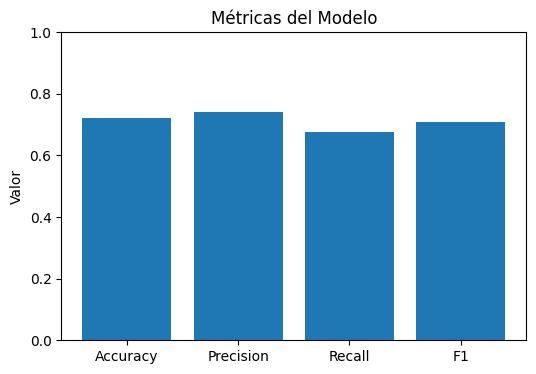

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(["Accuracy", "Precision", "Recall", "F1"], 
        [accuracy, precision, recall, f1])

plt.title("Métricas del Modelo")
plt.ylabel("Valor")
plt.ylim(0, 1)   # todas las métricas van entre 0 y 1

plt.show()


In [52]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import ChiSquareTest

# Seleccionar variables del modelo
features = ["age", "ap_hi", "ap_lo", "cholesterol", "gluc", "smoke", "alco", "active", "bmi"]

assembler = VectorAssembler(inputCols=features, outputCol="features_vec")
df_vec = assembler.transform(df_spark)  # usar tu DF original con las columnas

# Aplicar Chi-cuadrada
chi = ChiSquareTest.test(df_vec, "features_vec", "cardio").head()

#print("pValues:      ", chi.pValues)
#print("degreesOfFreedom:", chi.degreesOfFreedom)
#print("statistics:      ", chi.statistics)

# Mostrar resultados organizados
for f, p, stat in zip(features, chi.pValues, chi.statistics):
    print(f"{f:15} --> χ² = {stat:.3f}   p-value = {p:.6f}")


age             --> χ² = 11785.151   p-value = 0.000000
ap_hi           --> χ² = 15504.389   p-value = 0.000000
ap_lo           --> χ² = 9946.537   p-value = 0.000000
cholesterol     --> χ² = 3423.439   p-value = 0.000000
gluc            --> χ² = 586.912   p-value = 0.000000
smoke           --> χ² = 16.787   p-value = 0.000042
alco            --> χ² = 3.761   p-value = 0.052453
active          --> χ² = 88.981   p-value = 0.000000
bmi             --> χ² = 6391.627   p-value = 0.000000
